In [32]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import time
import sys
sys.path.insert(0,'..') 
from utils import  * #evaluator, to_sequences, lstm_1, lstm_2, autoencoder_1
#Librerias de TF

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ConvLSTM2D, LSTM, Dense, Dropout,LSTM, Flatten,RepeatVector,TimeDistributed
# keras modules
import keras_tuner as kt
from kerastuner.tuners import BayesianOptimization,RandomSearch
# Set Seed
tf.random.set_seed(1)

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import  mean_absolute_error

from scipy.signal import savgol_filter
#print(tf.__version__)
#Libreries for Espectral analysis
from scipy import signal

LOG_DIR = f'{int(time.time())}'

GPU is available


In [34]:
merge_cases_temp_precip = pd.read_csv("../Data/merge_cases_temperature_WeeklyPrecipitation_timeseries.csv")
merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)
merge_cases_temp_precip.LastDayWeek = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
    
dataset = merge_cases_temp_precip[['temperature_medellin','percipitation_medellin','cases_medellin']]
dataset["temperature_medellin"] = savgol_filter(dataset["temperature_medellin"], 5, 2)
dataset.index = merge_cases_temp_precip.LastDayWeek
    
train_dates = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
    
dataset.index = merge_cases_temp_precip.LastDayWeek
dataset.head(5)
    

C:\Users\cajas\.conda\envs\sebasmos\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\cajas\.conda\envs\sebasmos\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,temperature_medellin,percipitation_medellin,cases_medellin
LastDayWeek,,,
2007-01-06,21.007024,13.096688,1
2007-01-13,21.013048,8.437044,0
2007-01-20,21.011542,19.373165,0
2007-01-27,21.002505,0.000000,0
2007-02-03,20.989703,3.725206,0


In [35]:
import IPython
import IPython.display
import matplotlib as mpl
import datetime
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

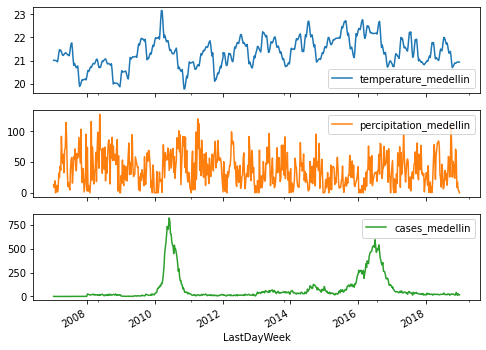

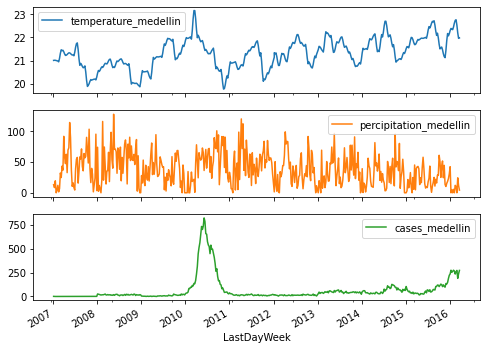

In [36]:
plot_cols = ['temperature_medellin', 'percipitation_medellin', 'cases_medellin']
plot_features = dataset[plot_cols]
plot_features.index = train_dates
_ = plot_features.plot(subplots=True)

plot_features = dataset[plot_cols][:480]
plot_features.index = train_dates[:480]
_ = plot_features.plot(subplots=True)

In [37]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature_medellin,624.0,21.344648,0.620252,19.775082,20.914265,21.329587,21.819252,23.145701
percipitation_medellin,624.0,37.754875,25.898445,0.000000,16.966976,34.649607,55.441882,127.111390
cases_medellin,624.0,77.357372,136.784064,0.000000,14.000000,26.000000,58.000000,820.000000


In [38]:
dataset = dataset.values
dataset = dataset.astype('float32') #COnvert values to float

    # Normalize
scaler = StandardScaler()
scaler = scaler.fit(dataset)
dataset = scaler.transform(dataset)
dataset.shape

(624, 3)

In [39]:

# Split dataset
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(train.shape)
print(test.shape)

n_future = 1   
n_past = 14
    
trainX, trainY = to_sequences(train, n_past, n_future)
testX, testY = to_sequences(test, n_past, n_future)
    
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

(561, 3)
(63, 3)
trainX shape == (547, 14, 3).
trainY shape == (547, 1).
testX shape == (49, 14, 3).
testY shape == (49, 1).


trainX shape == (547, 14, 3).
trainY shape == (547, 1).
testX shape == (49, 14, 3).
testY shape == (49, 1).
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 14, 96)            38400     
_________________________________________________________________
lstm_28 (LSTM)               (None, 14, 208)           253760    
_________________________________________________________________
lstm_29 (LSTM)               (None, 352)               789888    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 353       
Total params: 1,082,401
Trainable params: 1,082,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7/7 [==============================] - 3s 152ms/step - loss: 0.4495 - mae: 0.4495 - val_loss: 0.9816 - val_mae: 0.9816
Epoc

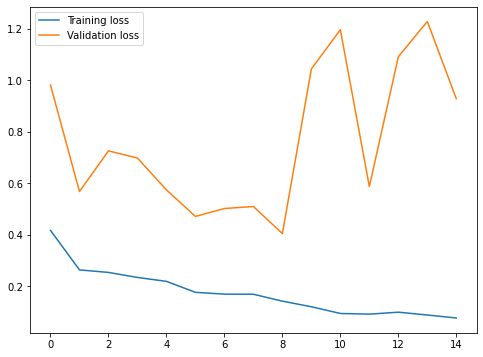

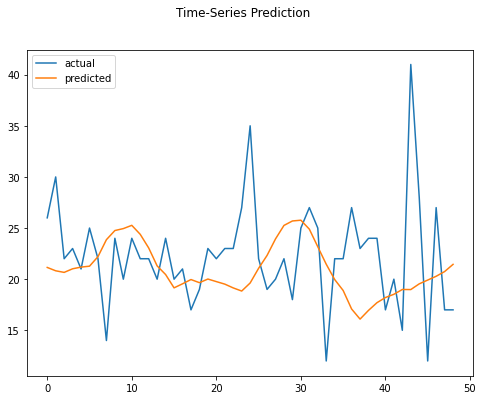

Train Score: 93.09 RMSE
Test Score: 6.04 RMSE
Test MAE: 4.433


In [40]:
n_future = 1   
n_past = 14

trainX, trainY = to_sequences(train, n_past, n_future)
testX, testY = to_sequences(test, n_past, n_future)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

#model = lstm_1(trainX,trainY)
model = lstm(trainX,trainY)

# fit the model
history = model.fit(trainX, trainY, epochs=15, batch_size=64, validation_split=0.2, verbose=1)

plt.figure(0)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


y_train_pred = model.predict(trainX)
y_train_pred = y_train_pred.squeeze()
y_test_pred = model.predict(testX)
y_test_pred = y_test_pred.squeeze()


trainScore,testScore,mae = evaluator(scaler, dataset, y_train_pred,trainY, y_test_pred,testY)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
print('Test MAE: %.3f' % mae)


In [14]:
# Updated dataset for 2021

merge_cases_temp_precip = pd.read_csv("../Data/merge_cases_WeeklyTemperature_WeeklyPrecipitation_timeseries.csv")
merge_cases_temp_precip = merge_cases_temp_precip.drop('Unnamed: 0', 1)
merge_cases_temp_precip.LastDayWeek = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
    
dataset = merge_cases_temp_precip[['temperature','percipitation_medellin','cases_medellin']]
dataset.index = merge_cases_temp_precip.LastDayWeek
    
train_dates = pd.to_datetime(merge_cases_temp_precip.LastDayWeek)
    
dataset.index = merge_cases_temp_precip.LastDayWeek

C:\Users\cajas\.conda\envs\sebasmos\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


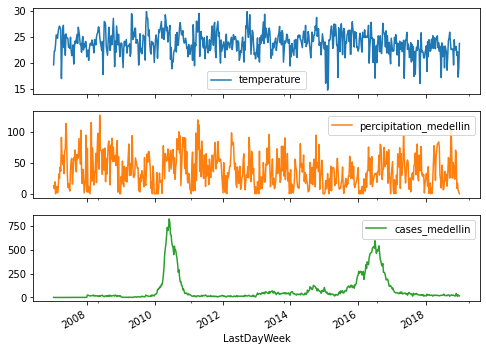

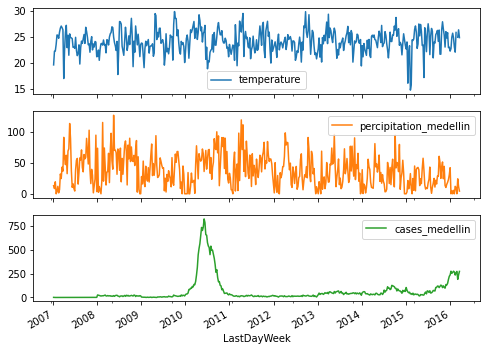

In [15]:
plot_cols = ['temperature', 'percipitation_medellin', 'cases_medellin']
plot_features = dataset[plot_cols]
plot_features.index = train_dates
_ = plot_features.plot(subplots=True)

plot_features = dataset[plot_cols][:480]
plot_features.index = train_dates[:480]
_ = plot_features.plot(subplots=True)

In [16]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,623.0,23.814574,2.254553,14.783286,22.493071,23.826071,25.249464,29.841857
percipitation_medellin,624.0,37.754875,25.898445,0.000000,16.966976,34.649607,55.441882,127.111390
cases_medellin,624.0,77.357372,136.784064,0.000000,14.000000,26.000000,58.000000,820.000000
